In [121]:
import pandas as pd
import torch
import torch.cuda
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from vocabulary import Vocabulary
from torch.optim import Adam
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from statistics import mean
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler  
from imblearn.under_sampling import RandomUnderSampler 




In [64]:
data = pd.read_csv('./data/antibody/merge2_5label.csv')

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.7, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [88]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list
    
# 将数据和标签处理成张量
def Seq_tensor(seq_list,max_len=500, is_seq=True):
    tensor = []
    if is_seq:
        for seq in seq_list:
            data = transform(seq, max_len)
            tensor.append(data)
        tensor = torch.LongTensor(tensor)
    else:
        tensor = torch.LongTensor(seq_list)
    return tensor

### 数据处理：欠采样+过采样

In [101]:
data1 = pd.read_csv('./data/processed_data2/PGT121.csv')
data1 = data1[data1["label"]!=2] #1251
X = data1['v3']
y = data1['label']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=1)
ros=RandomOverSampler(random_state=1)
X_train1,y_train1=ros.fit_resample(np.array(X_train1).reshape(-1, 1),y_train1)
X_train1 = X_train1[:1000]
y_train1 = y_train1[:1000]

X_train1 = Seq_tensor(X_train1.flatten(), 50)
y_train1 = Seq_tensor(np.array(y_train1), is_seq=False)

X_test1 = Seq_tensor(np.array(X_test1), 50)
y_test1 = Seq_tensor(np.array(y_test1), is_seq=False)

In [109]:
print(X_train1.shape)
print(y_train1.shape)
print(X_test1.shape)
print(y_test1.shape)

torch.Size([1000, 50])
torch.Size([1000])
torch.Size([376, 50])
torch.Size([376])


In [102]:
data2 = pd.read_csv('./data/processed_data2/VRC01.csv')
data2 = data2[data2["label"]!=2] #963
X = data2['CD4']
y = data2['label']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=1)
ros=RandomOverSampler(random_state=1)
X_train2,y_train2=ros.fit_resample(np.array(X_train2).reshape(-1, 1),y_train2)
X_train2 = X_train2[:1000]
y_train2 = y_train2[:1000]

X_train2 = Seq_tensor(X_train2.flatten(), 70)
y_train2 = Seq_tensor(np.array(y_train2), is_seq=False)

X_test2 = Seq_tensor(np.array(X_test2), 70)
y_test2 = Seq_tensor(np.array(y_test2), is_seq=False)

In [111]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

torch.Size([1000, 70])
torch.Size([1000])
torch.Size([289, 70])
torch.Size([289])


In [103]:
data3 = pd.read_csv('./data/processed_data2/3BNC117.csv')
data3 = data3[data3["label"]!=2] #943
X = data3['CD4']
y = data3['label']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=1)
ros=RandomOverSampler(random_state=1)
X_train3,y_train3=ros.fit_resample(np.array(X_train3).reshape(-1, 1),y_train3)
X_train3 = X_train3[:1000]
y_train3 = y_train3[:1000]

X_train3 = Seq_tensor(X_train3.flatten(), 70)
y_train3 = Seq_tensor(np.array(y_train3), is_seq=False)

X_test3 = Seq_tensor(np.array(X_test3), 70)
y_test3 = Seq_tensor(np.array(y_test3), is_seq=False)

In [112]:
print(X_train3.shape)
print(y_train3.shape)
print(X_test3.shape)
print(y_test3.shape)

torch.Size([1000, 70])
torch.Size([1000])
torch.Size([283, 70])
torch.Size([283])


In [104]:
data4 = pd.read_csv('./data/processed_data2/10-1074.csv')
data4 = data4[data4["label"]!=2] #987
X = data4['v3']
y = data4['label']
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.3, random_state=1)
ros=RandomOverSampler(random_state=1)
X_train4,y_train4=ros.fit_resample(np.array(X_train4).reshape(-1, 1),y_train4)

X_train4 = pd.Series(X_train4.flatten())
dic = {
    'input': X_train4,
    'label': y_train4
}
df = pd.DataFrame(dic)
df = df._append(df.sample(n=188, random_state=1), ignore_index=True)
X_train4 = df['input']
y_train4 = df['label']

X_train4 = Seq_tensor(np.array(X_train4), 50)
y_train4 = Seq_tensor(np.array(y_train4), is_seq=False)

X_test4 = Seq_tensor(np.array(X_test4), 50)
y_test4 = Seq_tensor(np.array(y_test4), is_seq=False)

In [113]:
print(X_train4.shape)
print(y_train4.shape)
print(X_test4.shape)
print(y_test4.shape)

torch.Size([1000, 50])
torch.Size([1000])
torch.Size([297, 50])
torch.Size([297])


In [108]:
data5 = pd.read_csv('./data/processed_data2/2F5.csv')
data5 = data5[data5["label"]!=2] #609
X = data5['GP41']
y = data5['label']
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.3, random_state=1)
ros=RandomOverSampler(random_state=1)
X_train5,y_train5=ros.fit_resample(np.array(X_train5).reshape(-1, 1),y_train5)

X_train5 = pd.Series(X_train5.flatten())
dic = {
    'input': X_train5,
    'label': y_train5
}
df = pd.DataFrame(dic)
df = df._append(df.sample(n=334, random_state=1), ignore_index=True)
X_train5 = df['input']
y_train5 = df['label']

X_train5 = Seq_tensor(np.array(X_train5), 400)
y_train5 = Seq_tensor(np.array(y_train5), is_seq=False)

X_test5 = Seq_tensor(np.array(X_test5), 400)
y_test5 = Seq_tensor(np.array(y_test5), is_seq=False)

In [114]:
print(X_train5.shape)
print(y_train5.shape)
print(X_test5.shape)
print(y_test5.shape)

torch.Size([1000, 400])
torch.Size([1000])
torch.Size([183, 400])
torch.Size([183])


In [115]:
class MultiTaskClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers, num_tasks, dropout):
        super(MultiTaskClassifier, self).__init__()
        self.shared_layers1 = nn.Sequential(
            # Embedding层
            nn.Embedding(input_size, hidden_size),
            # Transformer编码器
            nn.TransformerEncoder(
                nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
                num_layers )
        )
        self.shared_layers2 = nn.Sequential(
            nn.Linear(hidden_size, 64),  # Shared hidden layer
            nn.ReLU(),
            nn.Linear(64, 32),         # Shared hidden layer
            nn.ReLU()
        )
        self.classifiers = nn.ModuleList([nn.Linear(32, 2) for _ in range(num_tasks)])

    def forward(self, x):
        x = self.shared_layers1(x)
        # 平均池化
        x = torch.mean(x, dim=1)
        x = self.shared_layers2(x)
        outputs = [classifier(x) for classifier in self.classifiers]
        return outputs


In [126]:
num_tasks = 5  # Number of binary classification tasks
input_size = len(vocabulary)
hidden_size = 64
num_heads = 8
num_layers = 3
dropout = 0.1
# Instantiate the model
model = MultiTaskClassifier(input_size, hidden_size, num_heads, num_layers, num_tasks, dropout).to(device)

# Define loss functions and optimizers for each task
# criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam(classifier.parameters(), lr=0.01) for classifier in model.classifiers]

# load model
if os.path.exists("./model/MT/multi_task.pkl"):
    model.load_state_dict(torch.load("./model/MT/multi_task.pkl"))
    optimizers.load_state_dict(torch.load("./model/MT/MT_optimizer.pkl"))

In [127]:
# Define hyperparameters
num_epochs = 3000
batch_size = 32

# Combine data for all tasks into one DataLoader (you might need to adapt this based on your data)
dataset = TensorDataset(X_train1, y_train1, X_train2, y_train2, X_train3, y_train3, X_train4, y_train4, X_train5, y_train5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_file = pd.DataFrame(columns=['epoch_num', 'loss_task1', 'loss_task2', 'loss_task3', 'loss_task4', 'loss_task5', 'loss_mean'])
# Training loop
data_bar = tqdm(range(num_epochs))
for epoch in data_bar:
    loss_list1, loss_list2, loss_list3, loss_list4, loss_list5 = [],[],[],[],[] # record loss of 5 tasks respectively
    loss_mean = None #record even loss of 5 tasks
    for batch in loader:
        # Split data into inputs and labels for each task
        X_train1, y_train1, X_train2, y_train2, X_train3, y_train3, X_train4, y_train4, X_train5, y_train5 = batch
       
        X_train1 = X_train1.to(device)
        X_train2 = X_train2.to(device)
        X_train3 = X_train3.to(device)
        X_train4 = X_train4.to(device)
        X_train5 = X_train5.to(device)

        y_train1 = y_train1.to(device)
        y_train2 = y_train2.to(device)
        y_train3 = y_train3.to(device)
        y_train4 = y_train4.to(device)
        y_train5 = y_train5.to(device)
        

        # Zero the gradients for all optimizers
        for optimizer in optimizers:
            optimizer.zero_grad()

        # Forward pass and backward pass for each task
        outputs_task1 = model(X_train1)
        loss_task1 = criterion(outputs_task1[0], y_train1)  # Assuming the first classifier corresponds to task 1
        loss_task1.backward()
        optimizers[0].step()
        loss_list1.append(loss_task1.item())

        # Repeat for tasks 2 to 5
        # ...
        outputs_task2 = model(X_train2)
        loss_task2 = criterion(outputs_task2[1], y_train2)  # Assuming the first classifier corresponds to task 2
        loss_task2.backward()
        optimizers[1].step()
        loss_list2.append(loss_task2.item())

        outputs_task3 = model(X_train3)
        loss_task3 = criterion(outputs_task3[2], y_train3)  # Assuming the first classifier corresponds to task 3
        loss_task3.backward()
        optimizers[2].step()
        loss_list3.append(loss_task3.item())

        outputs_task4 = model(X_train4)
        loss_task4 = criterion(outputs_task4[3], y_train4)  # Assuming the first classifier corresponds to task 4
        loss_task4.backward()
        optimizers[3].step()
        loss_list4.append(loss_task4.item())

        outputs_task5 = model(X_train5)
        loss_task5 = criterion(outputs_task5[4], y_train5)  # Assuming the first classifier corresponds to task 5
        loss_task5.backward()
        optimizers[4].step()
        loss_list5.append(loss_task5.item())

        loss_mean = mean(loss_list1+loss_list2+loss_list3+loss_list4+loss_list5)
    
    # record all loss value
    loss_dic = {
        "epoch_num": epoch+1,
        "loss_task1": mean(loss_list1),
        "loss_task2": mean(loss_list2),
        "loss_task3": mean(loss_list3),
        "loss_task4": mean(loss_list4),
        "loss_task5": mean(loss_list5),
        "loss_mean": loss_mean,
    }
    loss_dic = pd.Series(loss_dic)
    loss_file = loss_file._append(loss_dic, ignore_index = True)

    # Save models every 10 epochs
    # if (epoch + 1) % 10 == 0:
    #     torch.save(model.state_dict(), "./model/MT/multi_task.pkl")
    #     torch.save(optimizers.state_dict(), "./model/MT/MT_optimizer.pkl")
    
    # Print the loss every 10 epochs0
    if (epoch + 1) % 200 == 0:
        data_bar.set_description("epoch:"+str(epoch+1)+"/2000")
        print(f'Loss (Task 1): {(mean(loss_list1)):.4f}, Loss (Task 2): {(mean(loss_list2)):.4f}, Loss (Task 3): {(mean(loss_list3)):.4f}, Loss (Task 4): {(mean(loss_list4)):.4f}, Loss (Task 5): {(mean(loss_list5)):.4f}, Even Loss: {loss_mean:.4f}')


epoch:200/2000:   7%|▋         | 204/3000 [00:06<01:26, 32.26it/s]

Loss (Task 1): 0.6731, Loss (Task 2): 0.5971, Loss (Task 3): 0.6443, Loss (Task 4): 0.6341, Loss (Task 5): 0.6174, Even Loss: 0.6332


epoch:400/2000:  13%|█▎        | 404/3000 [00:12<01:19, 32.65it/s]

Loss (Task 1): 0.6323, Loss (Task 2): 0.5662, Loss (Task 3): 0.6262, Loss (Task 4): 0.5323, Loss (Task 5): 0.6097, Even Loss: 0.5934


epoch:600/2000:  20%|██        | 604/3000 [00:18<01:13, 32.61it/s]

Loss (Task 1): 0.6189, Loss (Task 2): 0.5494, Loss (Task 3): 0.6141, Loss (Task 4): 0.5100, Loss (Task 5): 0.5987, Even Loss: 0.5782


epoch:800/2000:  27%|██▋       | 804/3000 [00:24<01:08, 32.15it/s]

Loss (Task 1): 0.6172, Loss (Task 2): 0.5404, Loss (Task 3): 0.6055, Loss (Task 4): 0.5253, Loss (Task 5): 0.5868, Even Loss: 0.5750


epoch:1000/2000:  33%|███▎      | 1004/3000 [00:31<01:01, 32.33it/s]

Loss (Task 1): 0.5903, Loss (Task 2): 0.5226, Loss (Task 3): 0.5633, Loss (Task 4): 0.4785, Loss (Task 5): 0.5782, Even Loss: 0.5466


epoch:1200/2000:  40%|████      | 1204/3000 [00:37<00:55, 32.14it/s]

Loss (Task 1): 0.6022, Loss (Task 2): 0.4819, Loss (Task 3): 0.5169, Loss (Task 4): 0.4742, Loss (Task 5): 0.5755, Even Loss: 0.5301


epoch:1400/2000:  47%|████▋     | 1404/3000 [00:43<00:48, 32.61it/s]

Loss (Task 1): 0.5846, Loss (Task 2): 0.4839, Loss (Task 3): 0.5663, Loss (Task 4): 0.3773, Loss (Task 5): 0.5642, Even Loss: 0.5153


epoch:1600/2000:  53%|█████▎    | 1604/3000 [00:49<00:43, 32.15it/s]

Loss (Task 1): 0.5543, Loss (Task 2): 0.4747, Loss (Task 3): 0.5092, Loss (Task 4): 0.4505, Loss (Task 5): 0.5594, Even Loss: 0.5096


epoch:1800/2000:  60%|██████    | 1804/3000 [00:56<00:37, 32.22it/s]

Loss (Task 1): 0.5568, Loss (Task 2): 0.5037, Loss (Task 3): 0.5773, Loss (Task 4): 0.4533, Loss (Task 5): 0.5536, Even Loss: 0.5289


epoch:2000/2000:  67%|██████▋   | 2004/3000 [01:02<00:30, 32.23it/s]

Loss (Task 1): 0.5304, Loss (Task 2): 0.4292, Loss (Task 3): 0.5564, Loss (Task 4): 0.4197, Loss (Task 5): 0.5708, Even Loss: 0.5013


epoch:2200/2000:  73%|███████▎  | 2204/3000 [01:08<00:24, 32.41it/s]

Loss (Task 1): 0.5367, Loss (Task 2): 0.4444, Loss (Task 3): 0.5100, Loss (Task 4): 0.3382, Loss (Task 5): 0.5260, Even Loss: 0.4711


epoch:2400/2000:  80%|████████  | 2404/3000 [01:14<00:18, 32.02it/s]

Loss (Task 1): 0.5391, Loss (Task 2): 0.4284, Loss (Task 3): 0.4792, Loss (Task 4): 0.3880, Loss (Task 5): 0.5415, Even Loss: 0.4752


epoch:2600/2000:  87%|████████▋ | 2604/3000 [01:20<00:12, 31.95it/s]

Loss (Task 1): 0.5533, Loss (Task 2): 0.4584, Loss (Task 3): 0.4801, Loss (Task 4): 0.4729, Loss (Task 5): 0.5606, Even Loss: 0.5051


epoch:2800/2000:  93%|█████████▎| 2804/3000 [01:27<00:06, 32.04it/s]

Loss (Task 1): 0.4989, Loss (Task 2): 0.4227, Loss (Task 3): 0.4855, Loss (Task 4): 0.4513, Loss (Task 5): 0.5053, Even Loss: 0.4728


epoch:3000/2000: 100%|██████████| 3000/3000 [01:33<00:00, 32.19it/s]

Loss (Task 1): 0.5971, Loss (Task 2): 0.3978, Loss (Task 3): 0.4879, Loss (Task 4): 0.4488, Loss (Task 5): 0.5278, Even Loss: 0.4919


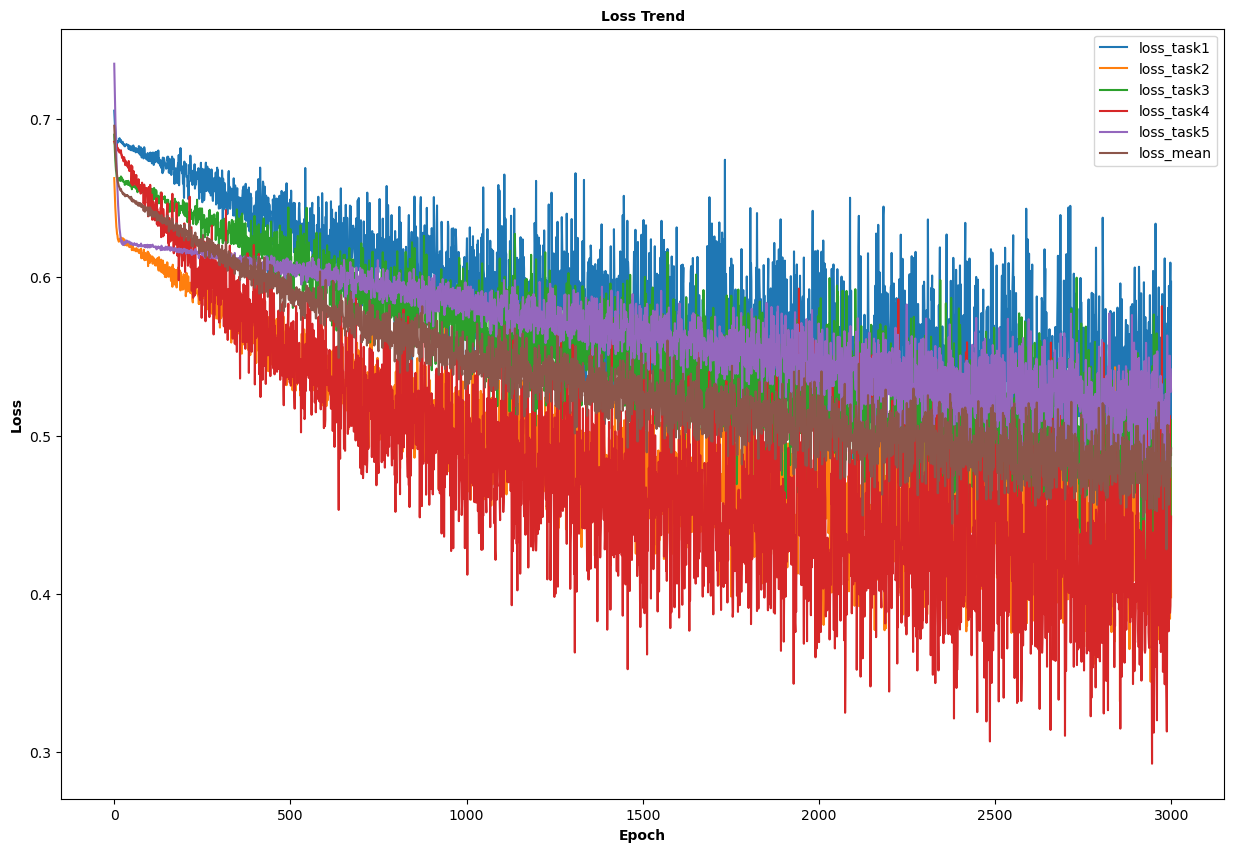

In [128]:
# SVM_df = pd.read_csv("./result/SVM_regression.csv")
# labels = np.array(list(SVM_df["Target"]))
# x = np.array(range(12))
loss_task1 = np.array(list(loss_file["loss_task1"]))
loss_task2 = np.array(list(loss_file["loss_task2"]))
loss_task3 = np.array(list(loss_file["loss_task3"]))
loss_task4 = np.array(list(loss_file["loss_task4"]))
loss_task5 = np.array(list(loss_file["loss_task5"]))
loss_mean = np.array(list(loss_file["loss_mean"]))

fig = plt.figure(figsize=(15, 10))

plt.plot(loss_task1, label="loss_task1")
plt.plot(loss_task2, label="loss_task2")
plt.plot(loss_task3, label="loss_task3")
plt.plot(loss_task4, label="loss_task4")
plt.plot(loss_task5, label="loss_task5")
plt.plot(loss_mean, label="loss_mean")


plt.title("Loss Trend", fontdict={"size":10, "weight":"bold"})
plt.xlabel("Epoch", fontdict={"size":10, "weight":"bold"})
plt.ylabel("Loss", fontdict={"size":10, "weight":"bold"})
# plt.xticks(fontsize=12,ticks=x, labels=labels, rotation=-15)  # 设置x轴刻度字体大小
# plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
# plt.ylim(0, 1)
# plt.grid()
plt.legend()
plt.savefig('./img/loss3.png')
plt.show()

In [132]:
# model.eval()

dataset1 = TensorDataset(X_test1, y_test1)
loader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True)

dataset2 = TensorDataset(X_test2, y_test2)
loader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

dataset3 = TensorDataset(X_test3, y_test3)
loader3 = DataLoader(dataset3, batch_size=batch_size, shuffle=True)

dataset4 = TensorDataset(X_test4, y_test4)
loader4 = DataLoader(dataset4, batch_size=batch_size, shuffle=True)

dataset5 = TensorDataset(X_test5, y_test5)
loader5 = DataLoader(dataset5, batch_size=batch_size, shuffle=True)

predict_1, predict_2, predict_3, predict_4, predict_5 = [],[],[],[],[]
real_1, real_2, real_3, real_4, real_5 = [],[],[],[],[]

loader_list = [loader1,loader2,loader3,loader4,loader5]
# Evaluation loop
for index, loader in enumerate(loader_list):
    for batch in loader:
        # Split data into inputs and labels for each task
        X_test, y_test = batch
        
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        # y_test2 = y_test2.to(device)
        # y_test3 = y_test3.to(device)
        # y_test4 = y_test4.to(device)
        # y_test5 = y_test5.to(device)
        

        with torch.no_grad():
            outputs = model(X_test)
            # predict value and real value
            if index == 0:
                predict_1 = predict_1 + torch.argmax(outputs[0], dim=1).cpu().tolist()
                real_1 = real_1 + y_test.cpu().tolist()
            if index == 1:
                predict_2 = predict_2 + torch.argmax(outputs[1], dim=1).cpu().tolist()
                real_2 = real_2 + y_test.cpu().tolist()
            if index == 2:
                predict_3 = predict_3 + torch.argmax(outputs[2], dim=1).cpu().tolist()
                real_3 = real_3 + y_test.cpu().tolist()
            if index == 3:
                predict_4 = predict_4 + torch.argmax(outputs[3], dim=1).cpu().tolist()
                real_4 = real_4 + y_test.cpu().tolist()
            if index == 4:
                predict_5 = predict_5 + torch.argmax(outputs[4], dim=1).cpu().tolist()
                real_5 = real_5 + y_test.cpu().tolist()

         

# Accuracy score
accuracy_1 = accuracy_score(real_1, predict_1)
accuracy_2 = accuracy_score(real_2, predict_2)
accuracy_3 = accuracy_score(real_3, predict_3)
accuracy_4 = accuracy_score(real_4, predict_4)
accuracy_5 = accuracy_score(real_5, predict_5)
acc_list = [accuracy_1,accuracy_2,accuracy_3,accuracy_4,accuracy_5]
print("acc_1:",accuracy_1,"acc_2:",accuracy_2,"acc_3:",accuracy_3,"acc_4:",accuracy_4,"acc_5:",accuracy_5)

# Precission score
precision_1 = precision_score(real_1, predict_1)
precision_2 = precision_score(real_2, predict_2)
precision_3 = precision_score(real_3, predict_3)
precision_4 = precision_score(real_4, predict_4)
precision_5 = precision_score(real_5, predict_5)
pre_list = [precision_1,precision_2,precision_3,precision_4,precision_5]       
print("pre_1:",precision_1,"pre_2:",precision_2,"pre_3:",precision_3,"pre_4:",precision_4,"pre_5:",precision_5)

# Recall score
recall_1 = recall_score(real_1, predict_1)
recall_2 = recall_score(real_2, predict_2)
recall_3 = recall_score(real_3, predict_3)
recall_4 = recall_score(real_4, predict_4)
recall_5 = recall_score(real_5, predict_5)
recall_list = [recall_1,recall_2,recall_3,recall_4,recall_5]    
print("recall_1:",recall_1,"recall_2:",recall_2,"recall_3:",recall_3,"recall_4:",recall_4,"recall_5:",recall_5)

# F1 score
f1_1 = f1_score(real_1, predict_1)
f1_2 = f1_score(real_2, predict_2)
f1_3 = f1_score(real_3, predict_3)
f1_4 = f1_score(real_4, predict_4)
f1_5 = f1_score(real_5, predict_5)
f1_list = [f1_1,f1_2,f1_3,f1_4,f1_5]
print("f1_1:",f1_1,"f1_2:",f1_2,"f1_3:",f1_3,"f1_4:",f1_4,"f1_5:",f1_5)

dic = {
    'accuracy':acc_list,
    'precision':pre_list,
    'recall':recall_list,
    'f1':f1_list
}
score = pd.DataFrame(dic, index=['PGT121','VRC01','3BNC117','10-1074','2F5'])
score.to_csv("./data_process_result/score.csv")


acc_1: 0.550531914893617 acc_2: 0.71280276816609 acc_3: 0.8303886925795053 acc_4: 0.4983164983164983 acc_5: 0.7595628415300546
pre_1: 0.5176470588235295 pre_2: 0.20754716981132076 pre_3: 0.35294117647058826 pre_4: 0.4105960264900662 pre_5: 0.7797619047619048
recall_1: 0.2558139534883721 recall_2: 0.21153846153846154 recall_3: 0.13953488372093023 recall_4: 0.5081967213114754 recall_5: 0.9492753623188406
f1_1: 0.34241245136186776 f1_2: 0.20952380952380956 f1_3: 0.2 f1_4: 0.4542124542124542 f1_5: 0.8562091503267973
